# Rio de Janeiro labelled satellite imagery from SpaceNet
# We will use this simple classifier to help tell our story about how NetApp's Data Fabric is a critical part of any MLOps data pipeline

# View the contents of the dataset

# How many images are there?

In [1]:
import os
from os.path import join
import json

In [2]:
images_folder = "data/processedBuildingLabels/3band/"
labels_folder = "data/processedBuildingLabels/vectordata/geojson"

In [3]:
print(len([name for name in os.listdir(images_folder)]), "satellite images")

6940 satellite images


In [4]:
print(len([name for name in os.listdir(labels_folder)]), "geojson labels")

6940 geojson labels


In [5]:
#print([name for name in os.listdir(images_folder)])

In [6]:
#print([name for name in os.listdir(labels_folder)])

In [7]:
geojson = [name for name in os.listdir(labels_folder)]

print(geojson[0])

Geo_AOI_1_RIO_img6180.geojson


In [8]:
geo1 = "data/processedBuildingLabels/vectordata/geojson/Geo_AOI_1_RIO_img5394.geojson"

with open(geo1, 'r') as j:
     contents = json.loads(j.read())

#print(contents)
print(json.dumps(contents, indent=4, sort_keys=True))

{
    "crs": {
        "properties": {
            "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
        },
        "type": "name"
    },
    "features": [
        {
            "geometry": {
                "coordinates": [
                    [
                        [
                            -43.55155559999997,
                            -22.8691751,
                            0.0
                        ],
                        [
                            -43.551554299999964,
                            -22.8692016,
                            0.0
                        ],
                        [
                            -43.55147594674406,
                            -22.869198345204104,
                            0.0
                        ],
                        [
                            -43.55147594674406,
                            -22.869275689623297,
                            0.0
                        ],
                        [
                    

# Read a few of the images into arrays

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

Try reading the first image.

Here is the last image.

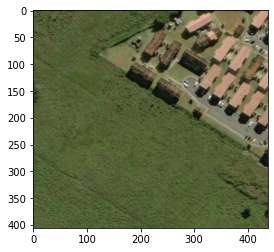

In [10]:
plt.imshow(np.array(Image.open(join(images_folder, os.listdir(images_folder)[-1]))));

# Read all the images into list of arrays

Converting to grayscale as they are opened.

In [11]:
images = [np.array(Image.open(join(images_folder, i)).convert('L')) for i in os.listdir(images_folder)]

In [12]:
print(images[11].shape)

(406, 438)


In [13]:
print(len(images), "images")

6940 images


In [14]:
images[0].shape

(406, 439)

In [15]:
cnt = 0
cnta = 0
cntb = 0
for i in range(len(images)):
 #   print(images[i].shape)
    if images[i].shape == (406,439):
        cnt += 1
    if images[i].shape == (406,438):
        cnta += 1
    if images[i].shape == (407, 439):
        cntb += 1
print('shape: (406, 439) count ',cnt)
print('shape: (406, 438) count ',cnta)
print('shape: (407, 439) count ',cntb)    

shape: (406, 439) count  3372
shape: (406, 438) count  3096
shape: (407, 439) count  472


# Resize some of the images so that they are all the same size

Some images have shape of (406, 438), others have shape of (406, 439).

Change the (406, 439)'s to (406, 438).

In [16]:
from tifffile import imread, imwrite
from skimage.transform import resize


In [17]:
for i in range(len(images)):
    if images[i].shape[1] == 439:    
        images[i] = np.delete(images[i], 439-1, axis=1)

Change the (407, 438)'s to (406, 438)'s.

In [18]:
for i in range(len(images)):
    if images[i].shape[0] == 407:
        images[i] = np.delete(images[i], 407-1, axis=0)

# Downsample the images so they are smaller.

In [19]:
from skimage.transform import downscale_local_mean

4x downsampling.

In [20]:
downscaled_images = []
for i in range(len(images)):
    downscaled_images.append(downscale_local_mean(images[i], (4,4)))

In [21]:
downscaled_images[0].shape

(102, 110)

Original image:

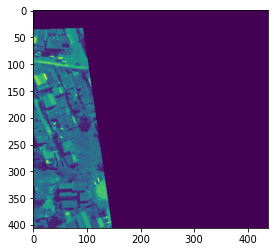

In [22]:
plt.imshow(images[0]);

Downscaled image:

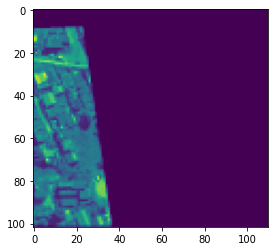

In [23]:
plt.imshow(downscaled_images[0]);

# Convert this list of downscaled arrays into a 3D array

In [24]:
shape = list(downscaled_images[0].shape)
shape[:0] = [len(downscaled_images)]
array_of_images = np.concatenate(downscaled_images).reshape(shape)

In [25]:
array_of_images.shape

(6940, 102, 110)

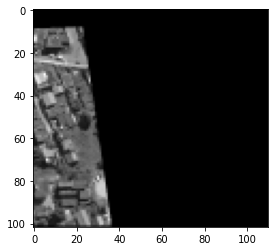

In [26]:
plt.imshow(array_of_images[0], cmap="gray");

# Parse the geojson labels for 1 = building, 0 = no building

In [27]:
import json

Read in all the geojsons.

In [28]:
labels = [json.load(open(join(labels_folder, i))) for i in os.listdir(labels_folder)]

# Create an array containing 1 = buildings, 0 = no buildings

In [29]:
def parse_labels(labels):
    
    results = []
    
    for label in labels:
        
        features = label['features']
        
        # If no features at all, append 0
        if len(features) == 0:
            results.append(0)
            
        # Otherwise, look for building property
        else:
            buildings_in_this_label = []
            for feature in features:
                properties = feature['properties']
                if 'building' in properties.keys():
                    if properties['building'] == 'yes':
                        buildings_in_this_label.append(1)
                    else:
                        buildings_in_this_label.append(0)
                else:
                    buildings_in_this_label.append(0)
            
            # If there is at least one building in this label, append 1
            if sum(buildings_in_this_label) > 0:
                results.append(1)
                
            # Otherwise append 0
            else:
                results.append(0)
                        
    array = np.array(results)
    return array

In [30]:
buildings_no_buildings = parse_labels(labels)

In [31]:
print(buildings_no_buildings.sum(), "of the", buildings_no_buildings.shape[0], "images contain buildings")

4302 of the 6940 images contain buildings


# Frame this as a machine learning problem

In [32]:
X = array_of_images
y = buildings_no_buildings

In [33]:
X.shape

(6940, 102, 110)

In [34]:
y.shape

(6940,)

# Split data into training and testing data

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
X_train.shape

(5205, 102, 110)

In [38]:
y_train.shape

(5205,)

In [39]:
X_test.shape

(1735, 102, 110)

In [40]:
y_test.shape

(1735,)

# Convolutional Neural Network

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')


In [42]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# reshape to be [samples][bands][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, X_train[0].shape[0], X_train[0].shape[1]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test[0].shape[0], X_test[0].shape[1]).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# convert label arrays to categorical
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [48]:
# define the model
def cnn():
    model = Sequential()
    
    model.add(Conv2D(50, (5, 5), input_shape=(1, X_train.shape[2], X_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
   
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['acc'])
    
    return model

In [49]:
# simple early stopping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(
    monitor='acc', 
    patience=8, 
    min_delta=0.001, 
    mode='auto'
)

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='auto', verbose=2, save_best_only=True)

In [ ]:
%%time
# build the model
model = cnn()
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)
# Final evaluation of the model
scores,acc = model.evaluate(X_test, y_test, verbose=0)
# print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/20
163/163 [==============================] - 7s 46ms/step - loss: 0.6706 - acc: 0.6171 - val_loss: 0.6676 - val_acc: 0.6265
Epoch 2/20
163/163 [==============================] - 6s 38ms/step - loss: 0.6686 - acc: 0.6177 - val_loss: 0.6644 - val_acc: 0.6265
Epoch 3/20
163/163 [==============================] - 6s 38ms/step - loss: 0.6678 - acc: 0.6177 - val_loss: 0.6642 - val_acc: 0.6265
Epoch 4/20
163/163 [==============================] - 6s 38ms/step - loss: 0.6682 - acc: 0.6177 - val_loss: 0.6635 - val_acc: 0.6265
Epoch 5/20
163/163 [==============================] - 6s 38ms/step - loss: 0.6666 - acc: 0.6177 - val_loss: 0.6609 - val_acc: 0.6265
Epoch 6/20
163/163 [==============================] - 6s 38ms/step - loss: 0.6668 - acc: 0.6177 - val_loss: 0.6635 - val_acc: 0.6265 - loss: 0.6672 - acc
Epoch 7/20
163/163 [==============================] - 6s 38ms/step - loss: 0.6659 - acc: 0.6177 - val_loss: 0.6615 - val_acc: 0.6265
Epoch 8/20
163/163 [============================

In [ ]:
print('Test score:', scores)
print('Test accuracy:', acc)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict_classes(X_test, batch_size=32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
y_test

In [ ]:
y_pred

Confusion matrix.

In [ ]:
import cv2
import numpy as np

In [ ]:
from sklearn.metrics import confusion_matrix
result=confusion_matrix(y_test, y_pred)
print(result)

# View the first 10 predictions

In [ ]:
def view_prediction_vs_actual(i, y_pred, X=X, y=y):
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.25, random_state=42)
    
    f, ax = plt.subplots()
    plt.imshow(X_test_orig[i], cmap='gray')
    
    prediction = ['no_building', 'building'][y_pred[i]]
    actual = ['no_building', 'building'][y_test_orig[i]]
    
    if prediction == actual:
        ax.annotate("CORRECT", (5,90), color='white', weight='bold',fontsize=16, bbox={'facecolor':'green', 'alpha':0.9, 'pad':5})
    else:
        ax.annotate("INCORRECT", (5,90), color='white', weight='bold',fontsize=16, bbox={'facecolor':'red', 'alpha':0.9, 'pad':5})
    
    ax.annotate("prediction:  " + prediction, (5, 10), color='white', weight='bold',fontsize=16)
    ax.annotate("actual:  " + actual, (5, 20), color='white', weight='bold',fontsize=16)
    
    return f

In [ ]:
for i in range(10):
    view_prediction_vs_actual(i, y_pred)